In [206]:
import os, csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties import unumpy as unp
from sklearn.metrics import r2_score
from scipy.signal import find_peaks

In [207]:
def get_data_from_path(path):
    # 读取文件内容
    with open(path, 'r', encoding='cp1252') as file:
        lines = file.readlines()

    # 创建字典来存储参数
    parameters = {}

    # 逐行读取文件内容
    for line in lines:
        # 去除行首尾的空白符
        line = line.strip()
        # 忽略空行和注释行
        if not line or line.startswith('#'):
            continue
        # 如果行包含等号，则将其解析为键值对
        if '=' in line:
            key, value = line.split('=')
            parameters[key.strip()] = value.strip()

        # 读取数据表格
    data_start = False
    # data = []
    times, hfs, amps = [], [], []

    for line in lines:
        if line.startswith("Depth ["):
            data_start = True
            continue
        if data_start and line.strip():
            # data.append(line.strip().split())
            time, hf, amp = line.strip().split()
            times.append(float(time))
            hfs.append(float(hf))
            amps.append(float(amp))

    times = np.array(times)
    hfs = np.array(hfs)
    amps= np.array(amps)

    return times, hfs, amps



# resolution power

嘗試把你寫code判斷過程寫出來？大概可以寫在caption裡？

resolution power threshold? 像是光學那樣？ 多少頻率會是可分辨的？

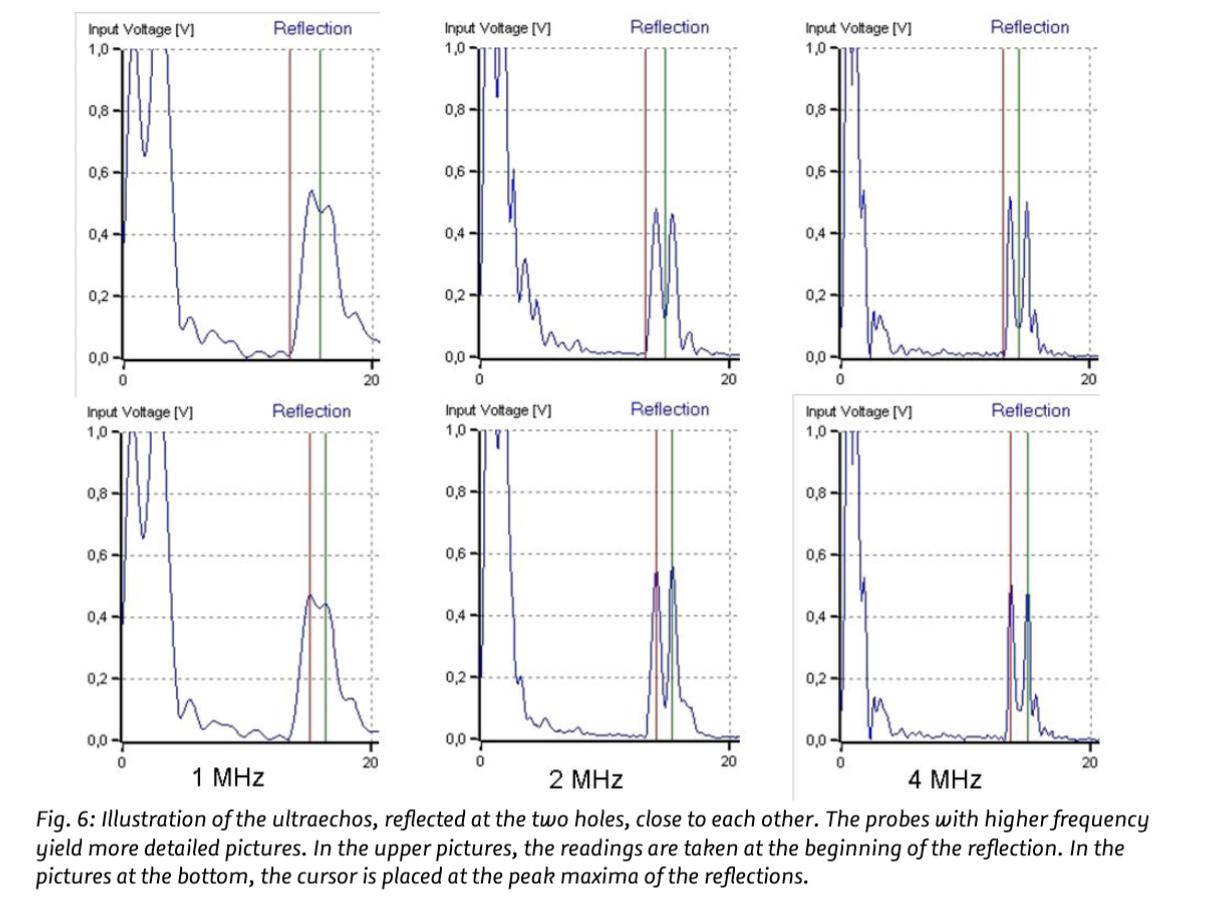

peak times diff distance []
peak times diff distance [1.8078]
start times diff distance [2.5116]
peak times diff distance [1.7112]
start times diff distance [1.7112]


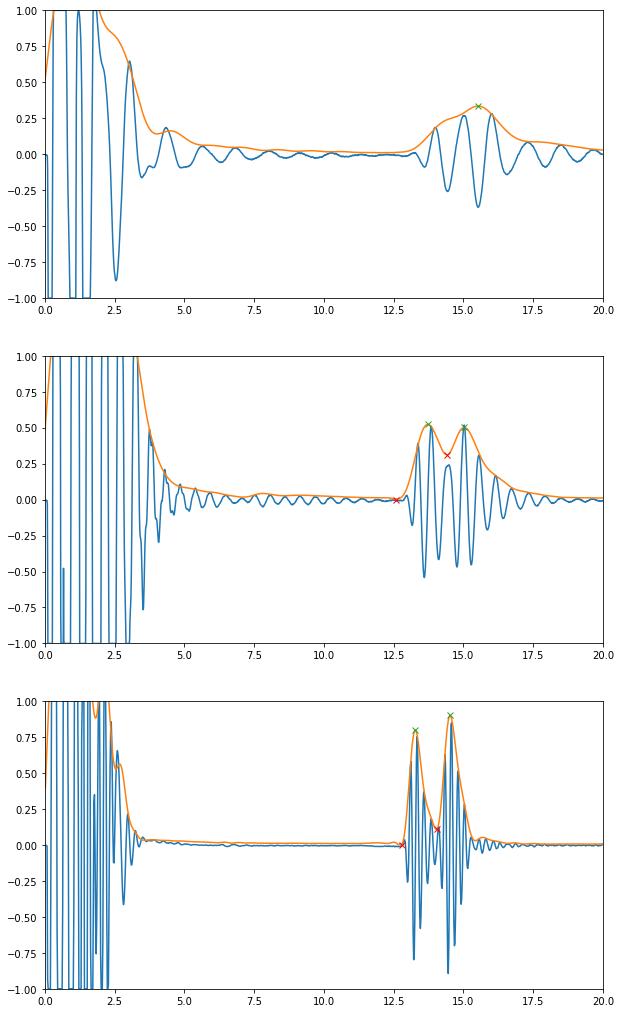

In [208]:
freqs = np.array([1,2,4])

plt.figure(figsize=(10, 18))

for i, freq in enumerate(freqs):
    plt.subplot(int(f'31{i+1}'))
    times, hfs, amps = get_data_from_path(os.getcwd()+f'/resolution/{freq}MHz.dat')

    mask = np.where((times<20)&(times>0))
    times, hfs, amps = times[mask], hfs[mask], amps[mask]
    dt = np.average(np.diff(times))


    plt.plot(times, hfs)
    plt.plot(times, amps)
    plt.xlim(0,20)
    plt.ylim(-1,1)

    peaks, _ = find_peaks(amps, distance = 1/dt, height = 0.25)

    peaks = peaks[np.where(times[peaks]>12.5)]

    plt.plot(peak_times:=times[peaks], amps[peaks], 'x')
    print('peak times diff distance',np.diff(peak_times)*1e-6 * 2760 / 2 * 1e3)

    if freq != 1:

        before_peaks = np.where((times < peak_times[0]) & (times > peak_times[0]-5))
        start = times[before_peaks][np.argmin(amps[before_peaks])]

        between_peaks = np.where((np.arange(0,len(times))>peaks[0] ) & ( np.arange(0,len(times))<peaks[1]))
        argmin, min = times[between_peaks][np.argmin(amps[between_peaks])], np.min(amps[between_peaks])
        plt.plot(start_times := [start, argmin], [0,min], 'x', color = 'red')

        print('start times diff distance', np.diff(start_times)*1e-6 * 2760 / 2 * 1e3)

# dimensions of the bulk

dim1: 1,2,4 measured 

dim2: 1,2,4

dim3: 1,2 (4 is unable to detect the echo)

PHY06: 80.46, 150.44, 42.00

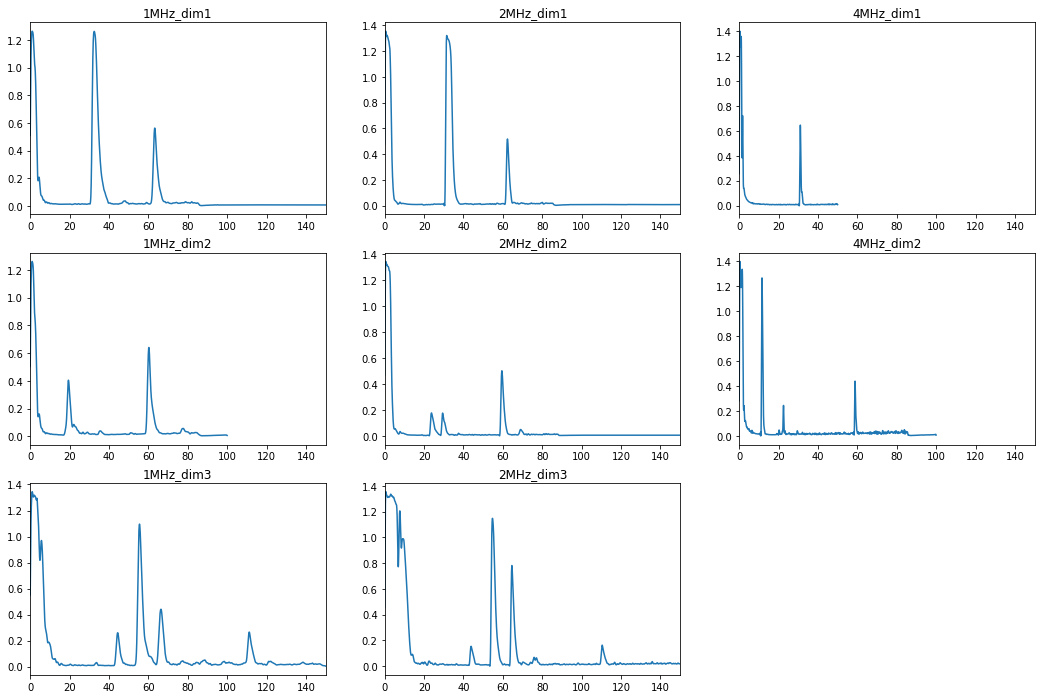

In [209]:
raw_data = np.zeros((3,3))
dims = np.array([1,2,3])

#  3i+j+1       freq 0  freq 1  freq2
# dim 0    1 2 3
# dim 1    4 5 6
# dim 2    7 8 9

plt.figure(figsize=(18,12))

for i in range(3):
    for j in range(3):
        if i == 2 and j == 2: break
        dim  = dims[i]
        freq = freqs[j]
        times, hfs, amps = get_data_from_path(os.getcwd()+f'/dimensions/{freq}MHz_dim{dim}.dat')
        plt.subplot(int(f'33{3*i+j+1}'))
        plt.plot(times, amps)
        plt.title(f'{freq}MHz_dim{dim}')
        plt.xlim(0,150)

# Pulse width of echo hole

pulse width 對 f 的理論值？

rename:
2-1  1
2-2  two hole
2-3  8
2-4  7
2-5  6
2-6  5
2-7  4
2-8  3
2-9  2

In [210]:
import os

def get_dat_paths(root_dir_relative):
    current_dir = os.getcwd()
    root_dir = os.path.abspath(os.path.join(current_dir, root_dir_relative))

    dat_paths = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.dat'):
                dat_paths.append(os.path.join(dirpath, filename))
    return dat_paths

paths = get_dat_paths('pulse_width/1MHz')

N = len(paths)

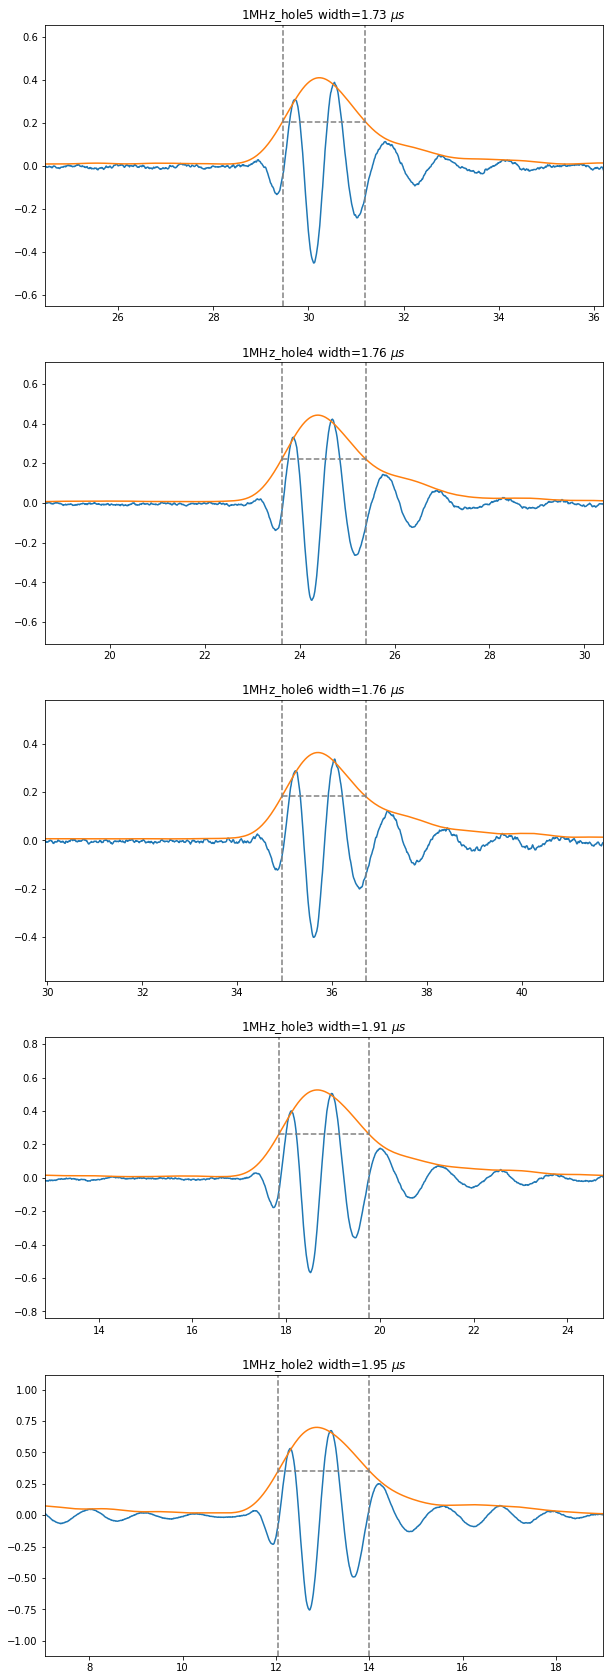

In [211]:
plt.figure(figsize=(10,6*N))

for i,path in enumerate(paths):
    times, hfs, amps = get_data_from_path(path)
    plt.subplot(int(f'{N}1{i+1}'))
    plt.plot(times, hfs)
    plt.plot(times, amps)
    
    xlim = (5,20)
    xlim = (10,40)
    mask = np.where((times > xlim[0])&(times < xlim[1]))
    times, hfs, amps = times[mask], hfs[mask], amps[mask]
    max = np.max(amps)
    over_half = np.where(amps - max / 2 > 0)
    plt.plot(t:=times[over_half], max / 2 * np.ones_like(t), linestyle='--', color = 'grey')
    half_start = np.min(t)
    half_end = np.max(t)

    plt.axvline(half_start, linestyle='--', color = 'grey')
    plt.axvline(half_end, linestyle='--', color = 'grey')

    width = half_end - half_start

    plt.title(path.split('/')[-1].removesuffix('.dat') + rf' width={width:.2f} $\mu s$')

    plt.xlim(half_start -5, half_end + 5)
    plt.ylim(-1.6*max, 1.6*max)
    

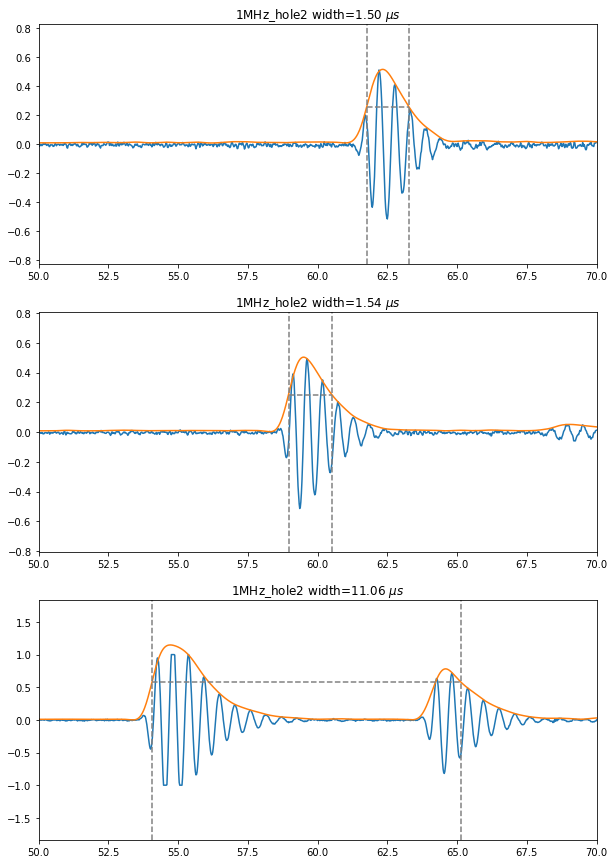

In [225]:
plt.figure(figsize=(10,15))

for i in range(3):
    dim  = dims[i]
    freq = freqs[1]
    times, hfs, amps = get_data_from_path(os.getcwd()+f'/dimensions/{freq}MHz_dim{dim}.dat')
    plt.subplot(int(f'31{i+1}'))
    plt.plot(times, hfs)
    plt.plot(times, amps)
    plt.title(f'{freq}MHz_dim{dim}')
    plt.xlim(50,70)

    xlim = (50,70)
    mask = np.where((times > xlim[0])&(times < xlim[1]))
    times, hfs, amps = times[mask], hfs[mask], amps[mask]
    max = np.max(amps)
    over_half = np.where(amps - max / 2 > 0)
    plt.plot(t:=times[over_half], max / 2 * np.ones_like(t), linestyle='--', color = 'grey')
    half_start = np.min(t)
    half_end = np.max(t)

    plt.axvline(half_start, linestyle='--', color = 'grey')
    plt.axvline(half_end, linestyle='--', color = 'grey')

    width = half_end - half_start

    plt.title(path.split('/')[-1].removesuffix('.dat') + rf' width={width:.2f} $\mu s$')

    # plt.xlim(half_start -5, half_end + 5)
    plt.ylim(-1.6*max, 1.6*max)